## PHY 410
### GPS Final Project
### Jeremy Kazimer

**---**

### Import Statements

In [1]:
# Python libraries:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pds

# Appending a path to get to utility files:
import sys
sys.path.append('utility')

# My utility libraries:
from get_data import *
from geographical_to_cartesian import *
from least_squares import *

### Preface

This is an exploration of data produced by `phyphox`'s GPS experiment.  Primarily, we focus on linear motion as it depicts the constant velocity walk that I had done in order to produce this data.

Note that whenever `Theory` is referred to, that can be found in the wiki in the github repository.

### Experiments
##### Converting the data to a sensible form

We begin the experiments by first loading a random dataset from the set of four files I recorded on December 3rd, 2020:

In [2]:
# np.random.choice(np.arange(1, 11)) picks an integer randomly from 1 - 10.
# .format() inserts that choice into the string at {}
filename = 'data/sample_{}.csv'.format(np.random.choice(np.arange(1, 7)))

print('working fi/le: {}'.format(filename))

working fi/le: data/sample_4.csv


We can display what the data typically looks like:

In [3]:
pds.read_csv(filename).head()

,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
0,0.000000,42.616768,-78.872401,375.288488,341.521362,0.67,104.599998,0.000456,5.360,8.0,0.0
1,0.387503,42.616769,-78.872396,375.158361,341.391235,0.67,103.699997,0.004044,5.360,8.0,0.0
2,1.400258,42.616761,-78.872353,378.139033,344.371948,0.75,93.000000,0.006141,3.216,4.0,9.0
3,2.399396,42.616757,-78.872328,376.524387,342.757324,1.21,98.000000,0.008170,3.216,3.0,17.0
4,3.402113,42.616752,-78.872304,376.839795,343.072754,0.88,97.900002,0.009623,3.216,3.0,18.0


Then, using my first helper library `get_data`, we load in the data in the form of a dictionary storing all the information that we care about:

In [4]:
position_dictionary = get_data(filename)

In [5]:
# Printing the keys, just to show what was stored:
print(position_dictionary.keys())

dict_keys(['time', 'latitude', 'longitude', 'altitude', 'z std', 'x & y std'])


Just to see the data in the geographical coordinate system, we can plot the main variables first as a function of time, then each other:

In [6]:
# Fetching the appropriate variables.
time = position_dictionary['time']

latitude = position_dictionary['latitude']
longitude = position_dictionary['longitude']
altitude = position_dictionary['altitude']

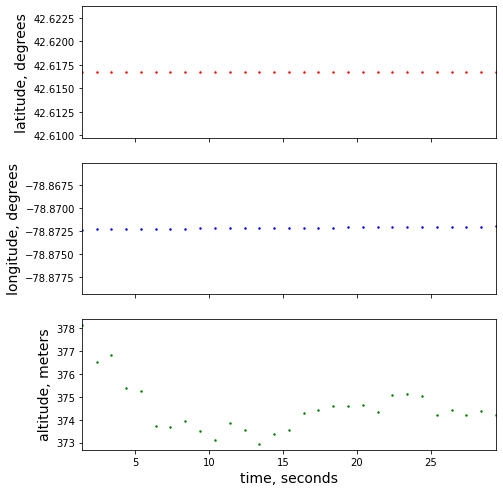

In [7]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, latitude, s = 2, c = 'red')
axs[1].scatter(time, longitude, s = 2, c = 'blue')
axs[2].scatter(time, altitude, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('latitude, degrees', fontsize = 14)
axs[1].set_ylabel('longitude, degrees', fontsize = 14)
axs[2].set_ylabel('altitude, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_geographical_plot.pdf')

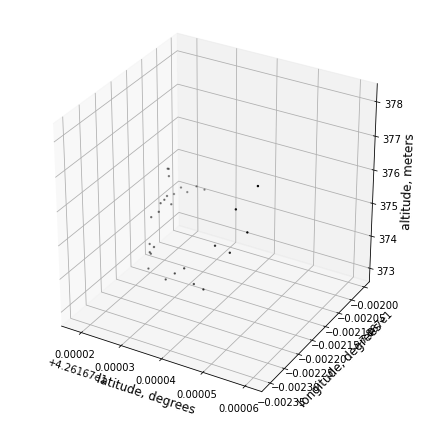

In [8]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(latitude, longitude, altitude, s = 2, c = 'k')

# Labels:
ax.set_xlabel('latitude, degrees', fontsize = 12)
ax.set_ylabel('longitude, degrees', fontsize = 12)
ax.set_zlabel('altitude, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_geographical_plot.pdf')

# Sorry for the "longitude" label.  I couldn't seem to move it.

This plot is fine and all, but, aforementioned, it means nothing to the average person for two reasons.  First, that it's in an unconventional coordinate system for everyday use.  We can address this by converting the system to Cartesian.  For this, we'll use the `geographical_to_cartesian` library (see *Theory* for explanation):

In [9]:
cartesian_system = convert_coordinates(latitude, longitude, altitude)

In [10]:
# Once again, printing the keys for convenience.
print(cartesian_system.keys())

dict_keys(['x', 'y', 'z'])


In [11]:
x, y, z = cartesian_system['x'], cartesian_system['y'], cartesian_system['z']

We can now repeat the same plots above, but for the new coordinate system:

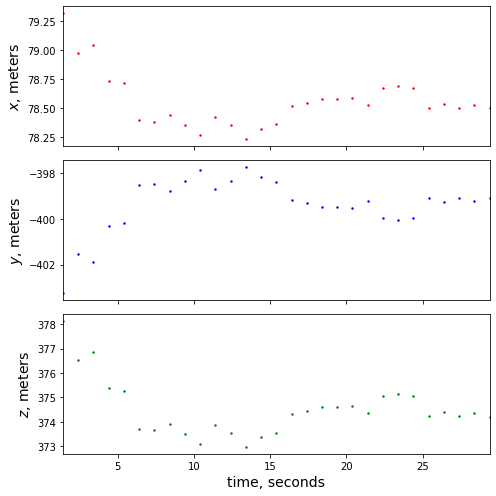

In [12]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, x, s = 2, c = 'red')
axs[1].scatter(time, y, s = 2, c = 'blue')
axs[2].scatter(time, z, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$x$, meters', fontsize = 14)
axs[1].set_ylabel('$y$, meters', fontsize = 14)
axs[2].set_ylabel('$z$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_cartesian_plot.pdf')

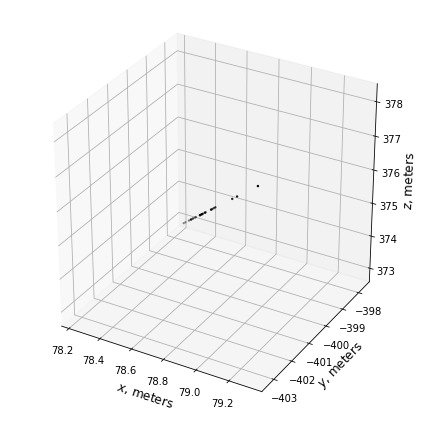

In [13]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(x, y, z, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$x$, meters', fontsize = 12)
ax.set_ylabel('$y$, meters', fontsize = 12)
ax.set_zlabel('$z$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_cartesian_plot.pdf')

This is fine.  With a little more knowledge, the user can understand that they're moving away from their starting point.  However, my second concern arises:  although it's fine that the origin is not defined by the starting point, it doesn't make much sense to not shift the data to the starting point.

To me, this is because shifting to the origin tells the user a lot more information without additional thought.  For example, "you are 10 meters down from home" is more sensical than "you are at 250 meters in the $z$".  

As such, the conversion is generically $ds = s - s_0$, where $s$ is any generic position variable and $s_0$ is the first point in this set.  Then, $dn$ is simply the change in that variable at any given point.  In Python:

In [14]:
dx = x - x[0]
dy = y - y[0]
dz = z - z[0]

And a demonstrative plot:

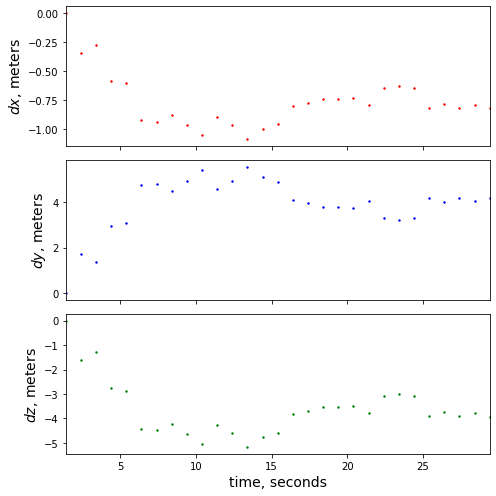

In [15]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, dx, s = 2, c = 'red')
axs[1].scatter(time, dy, s = 2, c = 'blue')
axs[2].scatter(time, dz, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$dx$, meters', fontsize = 14)
axs[1].set_ylabel('$dy$, meters', fontsize = 14)
axs[2].set_ylabel('$dz$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_relative_cartesian_plot.pdf')

For $dx$, consider that my driveway is straight east, so effectively the value should be $0$, but fluctuations occur due to standard error as well as maybe me walking incorrectly at points.

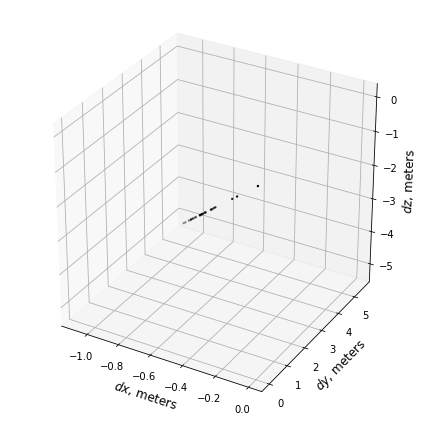

In [16]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(dx, dy, dz, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$dx$, meters', fontsize = 12)
ax.set_ylabel('$dy$, meters', fontsize = 12)
ax.set_zlabel('$dz$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_relative_cartesian_plot.pdf')

As suggested, the structure of the data doesn't really change that much (see _Theory_ for more).  To me, this is more interpretable for the average person.  Of course, it's unrealistic that the average person will see this, but it's far more reasonable to cater to the average than to the deviations.

The ultimate problem with this data, however, is the lack of data points; we could take a very long walk, but then we would face the same issue.  It's best to attempt to recreate the same walk, with the same initial conditions and length, and then merge the data such that we have a denser distribution in a shorter span of time.

##### Merging the data

Rather than taking a random subset of the data, we can instead look at all the releveant data and combine it.  This is rather easy in Python:

In [17]:
# The list of data that is compatible
data = np.arange(1, 6)

# It would be better to use, say, a numpy array
# of defined length but we won't have that much data.
x = np.array([]); y = np.array([]); z = np.array([])
std_x = np.array([]); std_y = np.array([]); std_z = np.array([])

time = np.array([]);
for datum in data:
    
    filename = 'data/sample_{}.csv'.format(datum)
    position_dictionary = get_data(filename)
    
    # Geographical position variables
    latitude = position_dictionary['latitude']
    longitude = position_dictionary['longitude']
    altitude = position_dictionary['altitude']

    cartesian_system = convert_coordinates(latitude, longitude, altitude)
    
    x = np.append(x, cartesian_system['x'])
    y = np.append(y, cartesian_system['y'])
    z = np.append(z, cartesian_system['z'])
    
    std_x = np.append(std_x, position_dictionary['x & y std'])
    std_y = np.append(std_y, position_dictionary['x & y std'])
    std_z = np.append(std_z, position_dictionary['z std'])
    
    time = np.append(time, position_dictionary['time'])

# Sort in case .plot is used, otherwise it'll look weird.
time_sort = np.argsort(time)
time = time[time_sort]

x = x[time_sort]; y = y[time_sort]; z = z[time_sort]
std_x = std_x[time_sort]; std_y = std_y[time_sort]; std_z = std_z[time_sort]

In [18]:
dx = x - x[0]
dy = y - y[0]
dz = z - z[0]
time = time - time[0]

We can now plot again, this time with the total data:

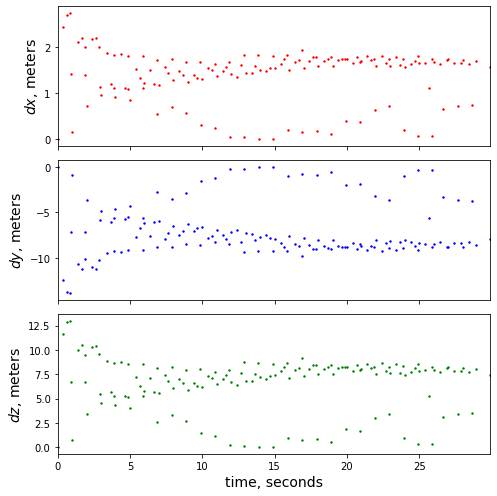

In [19]:
fig, axs = plt.subplots(3, 1, figsize = (7, 7), sharex = True)

# Plotting:
axs[0].scatter(time, dx, s = 2, c = 'red')
axs[1].scatter(time, dy, s = 2, c = 'blue')
axs[2].scatter(time, dz, s = 2, c = 'green')

# Limiting x-axis:
axs[2].set_xlim(time[0], time[-1])

# Labels:
axs[0].set_ylabel('$dx$, meters', fontsize = 14)
axs[1].set_ylabel('$dy$, meters', fontsize = 14)
axs[2].set_ylabel('$dz$, meters', fontsize = 14)

axs[2].set_xlabel('time, seconds', fontsize = 14)

fig.tight_layout()

fig.savefig('figures/2d_total_relative_cartesian_plot.pdf')

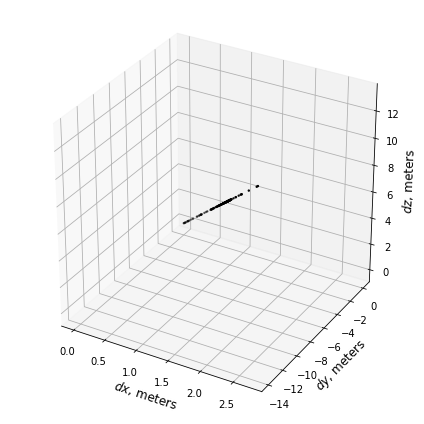

In [20]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting:
ax.scatter(dx, dy, dz, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$dx$, meters', fontsize = 12)
ax.set_ylabel('$dy$, meters', fontsize = 12)
ax.set_zlabel('$dz$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_total_relative_cartesian_plot.pdf')

The pure volume of plots may seem excessive, since they're effectively copies of each other.  However, I think it is important to show the transformations.  I also think that it's important to understand that a higher density of points it to our benefit, hence the last set of plots.

Consider that more points means that a lot of the statistical noise will start to dissolve such that a more accurate fit is formed.  Especially with something like `phyphox`, that at times cannot be trusted in their measurements.  

Regardless, we can now begin to fit the data:

##### Fitting the univariate data

The question then arises of how to fit the data.  First, it depends on what exactly is being predicted.  In the most basic case, $f(t)$ is a useful quantity to predict - it tells you where you should be as a function of time.  

Since time is purely linear (although this year has felt the opposite), we'll utilize least-squares (see `Theory`) to fit our model by the generic equation $s = v_s t$:

In [21]:
# By putting it in an array, we don't have to repeat code.
ds_array = [dx, dy, dz]

# As to more easily index.
std_array = [std_x, 
             std_y,
             std_z]

# 3 coefficients, 3 dimensions.
coefficients = np.zeros((3, 2))

for idx, ds in enumerate(ds_array):

    std_ds = std_array[idx]

    linear_coefficients = least_squares(ds, time, n = 1)
    
    coefficients[idx] = linear_coefficients

And now, a simple plot as demonstration:

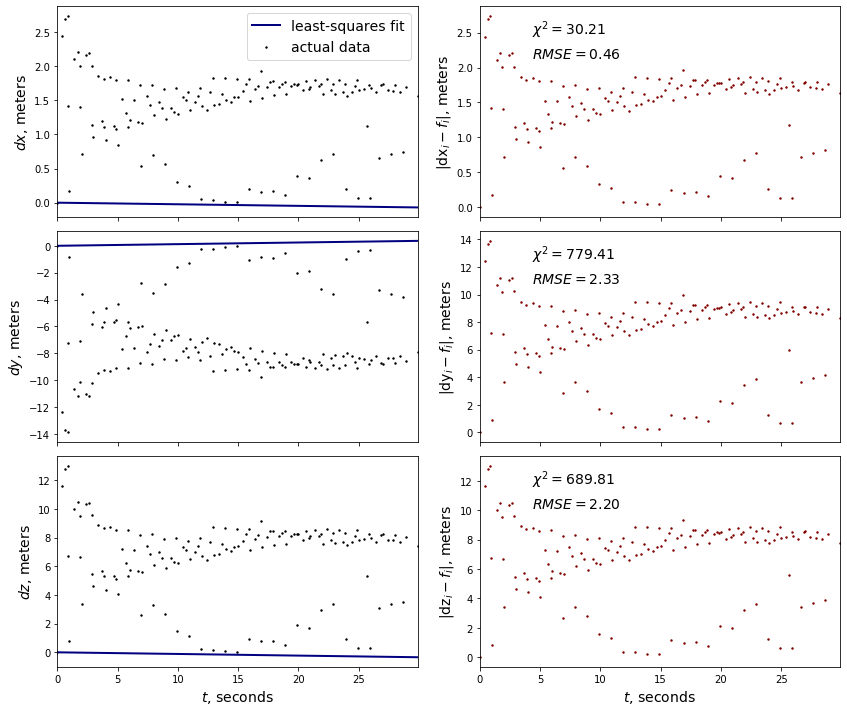

In [22]:
labels = [r'$dx$', r'$dy$', r'$dz$']

fig, axs = plt.subplots(3, 2, sharex = True, figsize = (12, 10))

for idx, label in enumerate(labels):
    
    # Pulling the prediction.  They stored in ascending power:
    coeff = coefficients[idx]
    fit = coeff[1]*time
    
    # First, the comparison of functions:
    axs[idx][0].scatter(time, ds_array[idx], s = 2, c = 'k', label = 'actual data')
    axs[idx][0].plot(time, fit, lw = 2, c = 'navy', label = 'least-squares fit')
    
    axs[idx][0].set_ylabel(label + ', meters', fontsize = 14)
    
    # Then the error:
    axs[idx][1].scatter(time, abs(ds_array[idx] - fit), c = 'maroon', s = 2)
    
    axs[idx][1].set_ylabel('$|{}_i - {}|$, meters'.format(label, 'f_i'), fontsize = 14)
    
    # Spoofing a legend to insert chi2:
    axs[idx][1].scatter(time[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$\chi^2 = {:.2f}$'.format(chi2(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].scatter(time[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$RMSE = {:.2f}$'.format(rmse(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    if idx == 2:
        axs[idx][0].set_xlabel('$t$, seconds', fontsize = 14)
        axs[idx][1].set_xlabel('$t$, seconds', fontsize = 14)
    
    axs[idx][0].set_xlim(time[0], time[-1])
    axs[idx][1].set_xlim(time[0], time[-1])
    
axs[0][0].legend(loc = 'upper right', fontsize = 14)
    
fig.tight_layout()

fig.savefig('figures/univariate_fit_plot.pdf')

Even for large enough data, we see that the fit is pretty bad.  The issue is that there exists too many outliers such that they cause the prediction to be negatively skewed, as evidenced by the scatterplot of high error.  Although there are plenty of dots tending towards zero, there are enough tending towards the max of the original data such that it shifts the results.  There also originally wasn't a trend in the time data, since position it related to time, but not necessarily time to position.  

There is arguably no correlation unless higher motion (or lower) is explored.  For example, the fit would suggest an initial position and acceleration that our physical model didn't foresee.  

However, since this predicts a physical system, we can print the coefficients such that we know initial acceleration, velocity, etc.:

In [23]:
coeff_dx = coefficients[0]

# I have it in a list in case the user wants
# to easily look at all the coefficients
# produced by fitting if they just 
# add the corresponding strings themselves.
labels = ['velocity']
units = ['m/s']

current_constant = 'initial {} in dx: {} {}'.format(labels[0], coeff_dx[1], units[0])
print(current_constant)

initial velocity in dx: -0.002326265131394581 m/s


In [24]:
coeff_dy = coefficients[1]
labels = ['velocity']
units = ['m/s']

current_constant = 'initial {} in dy: {} {}'.format(labels[0], coeff_dy[1], units[0])
print(current_constant)

initial velocity in dy: 0.012234279859720249 m/s


In [25]:
coeff_dz = coefficients[2]
labels = ['velocity']
units = ['m/s']

current_constant = 'initial {} in dz: {} {}'.format(labels[0], coeff_dz[1], units[0])
print(current_constant)

initial velocity in dz: -0.011469840237199005 m/s


Of course, initial position must be discarded since our system assumes $s_0 = 0$.  The only reason that it's not true here is because of the structure of the data.  With an infinite set of purely accurate points (i.e., $\sigma = 0$), then this would not be an issue.  But, alas, it is.  And it's the reason why the fit is so inaccurate.

We can then compare this to `numpy`'s built-in fitting function, `np.polyfit()`.  This takes in `x`, `y`, and the order of the polynomial.  Repeating code above, but this time for the comparison functions:

In [26]:
numpy_dx = np.polyfit(time, dx, 1)
labels = ['velocity']
units = ['m/s']

# Consider that numpy's indexing for variables is reversed.
current_constant = 'numpy initial {} in dx: {} {}'.format(labels[0], numpy_dx[0], units[0])
print(current_constant)

print('absolute difference between the two methods: {} {}'.format(abs(numpy_dx[0] - coeff_dx[1]), units[0]))

numpy initial velocity in dx: -0.002326265131394507 m/s
absolute difference between the two methods: 7.41594285980085e-17 m/s


In [27]:
numpy_dy = np.polyfit(time, dy, 1)
labels = ['velocity']
units = ['m/s']

current_constant = 'numpy initial {} in dy: {} {}'.format(labels[0], numpy_dy[0], units[0])
print(current_constant)

print('absolute difference between the two methods: {} {}'.format(abs(numpy_dy[0] - coeff_dy[1]), units[0]))

numpy initial velocity in dy: 0.012234279859719756 m/s
absolute difference between the two methods: 4.926614671774132e-16 m/s


In [28]:
numpy_dz = np.polyfit(time, dz, 1)
labels = ['velocity']
units = ['m/s']

current_constant = 'numpy initial {} in dz: {} {}'.format(labels[0], numpy_dz[0], units[0])
print(current_constant)

print('absolute difference between the two methods: {} {}'.format(abs(numpy_dz[0] - coeff_dz[1]), units[0]))

numpy initial velocity in dz: -0.011469840237199101 m/s
absolute difference between the two methods: 9.540979117872439e-17 m/s


As such, since the difference is either below machine precision ($1\times10^{-16}$) or right above, the difference in the two methods is effectively zero.  With that, either method is valid since they so closely produce values.  Really, the differences may only occur depending on how they truncate values compared to how my function truncates values.  If derived by hand, perhaps they would be exactly the same!

There is perhaps one last thing we can do in this section:  we have a closed form of $r$ in terms of $f(x, y, z, t) = r(t_i) = \sqrt{x(t_i)^2 + y(t_i)^2 + z(t_i)^2}$.  Since we know $x(t_i), y(t_i), z(t_i)$, we can compare that to the approximation by taking $s = v_st$ and substituting for each direction vector.  The exact solution can be found in `Theory`.  In Python, however:

In [29]:
# The actual r:
dr = np.sqrt(dx**2 + dy**2 + dz**2)
std_dr = np.sqrt(std_x**2 + std_y**2 + std_z**2)

# The coefficients:
vx, vy, vz = coefficients[:,1]

# The approximation:
dr_approx = np.sqrt(vx**2 + vy**2 + vz**2)*time

And, of course, a plot! Or several!

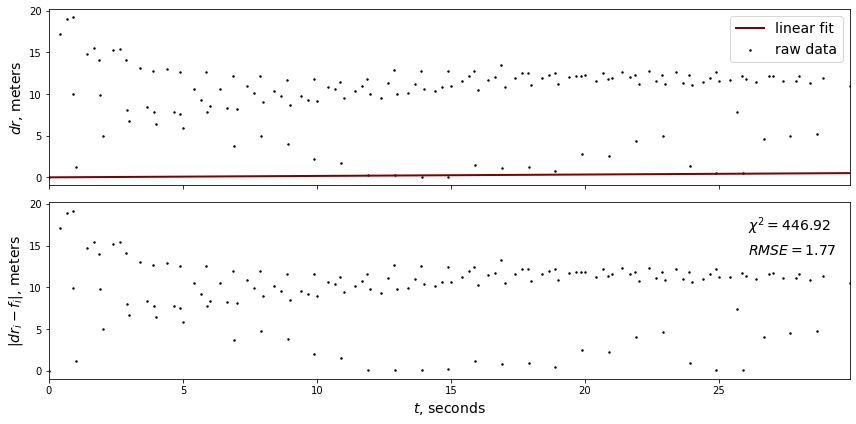

In [30]:
fig, axs = plt.subplots(2, 1, figsize = (12, 6), sharex = True)

# The comparison plots:

axs[0].scatter(time, dr, s = 2, c = 'k', label = 'raw data')
axs[0].plot(time, dr_approx, lw = 2, c = 'maroon', label = 'linear fit')

axs[0].set_ylabel('$dr$, meters', fontsize = 14)
axs[0].legend(loc = 'upper right', fontsize = 14)

# The error:
axs[1].scatter(time, abs(dr - dr_approx), s = 2, c = 'k')

axs[1].set_ylabel('$|dr_i - f_i|$, meters', fontsize = 14)
axs[1].set_xlabel('$t$, seconds', fontsize = 14)

axs[1].set_xlim(time[0], time[-1])

# Spoofing a legend:
axs[1].scatter(time[0], abs(dr - dr_approx)[0],
                       s = 0,
                       label = r'$\chi^2 = {:.2f}$'.format(chi2(dr, dr_approx, std_dr)))
    
axs[1].scatter(time[0], abs(dr - dr_approx)[0],
                       s = 0,
                       label = r'$RMSE = {:.2f}$'.format(rmse(dr, dr_approx, std_dr)))

axs[1].legend(loc = 'upper right', fontsize = 14, frameon = False)

fig.tight_layout()

fig.savefig('figures/radial_fit_plot.pdf')

Much like the other experiments, this one suffers for the same reasons.  In fact, the fit is almost negligible.  But...there has to be better.  We have to be able to do better! And we can...in the next section!  

##### Fitting the multivariate data

We can now repeat the process, but this time treating the data such that we can fit the data according to the notion that $s = \dfrac{v_s}{v_q}q$, where $q$ is an orthogonal position vector (see `Theory`).  In code, we'll reject $c_0$ since we anticipate that it converges to zero:

In [31]:
pos_coefficients = np.zeros(3)

# Position coefficients
pos_coefficients[0] = least_squares(dx, dy, n = 1)[1]
pos_coefficients[1] = least_squares(dy, dx, n = 1)[1]
pos_coefficients[2] = least_squares(dz, dy, n = 1)[1]

In [32]:
print('proportion of velocities:')
print(pos_coefficients)

proportion of velocities:
[-0.19667606 -5.08449174 -0.93770121]


And just quickly to show that the notion expressed in `Theory` (that we can't just take the proportion of the time-dependent coefficients) holds true:

In [33]:
time_props = [coeff_dx[1]/coeff_dy[1], coeff_dy[1]/coeff_dx[1], coeff_dz[1]/coeff_dy[1]]

print('proportion of velocities from time-dependent fit:')
print(time_props)

proportion of velocities from time-dependent fit:
[-0.1901432007496822, -5.259194102430567, -0.9375165819904071]


So, they're very close, but a difference exists such that certainly the coefficients produced by fitting according to the equation of this section.  Mainly because the error in the time-dependent fit will reflect in an increased error in the time-independent fit.  However, it is good verification that they're similar - it suggests that both methods are either correct or both wrong.  

Regardless, we can then plot the data to reflect these predictions:

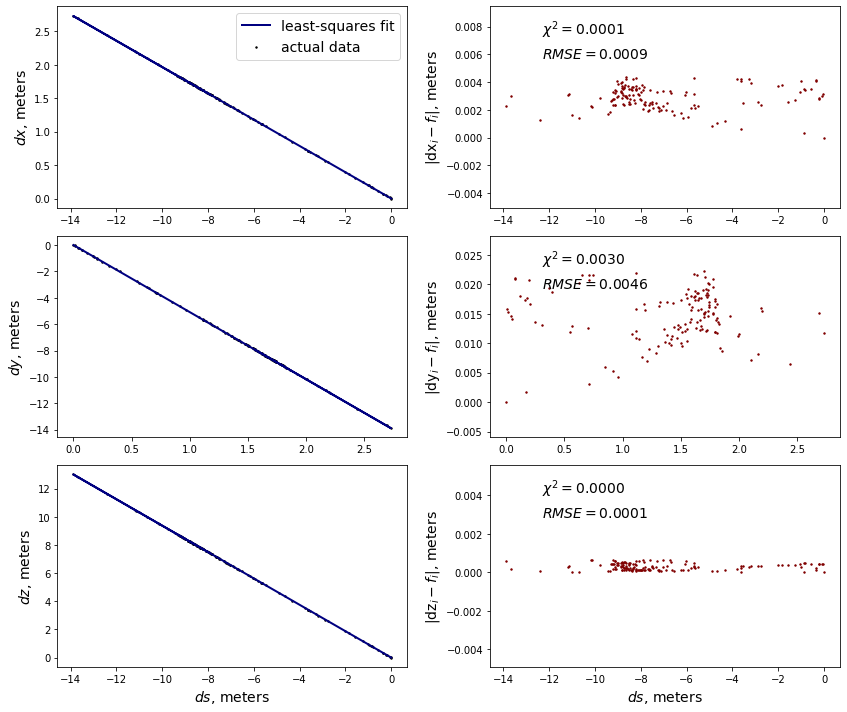

In [34]:
labels = [r'$dx$', r'$dy$', r'$dz$']

# Storing a list of tuples makes indexing a bit easier.
props = [(dx, dy), (dy, dx), (dz, dy)]

fig, axs = plt.subplots(3, 2, figsize = (12, 10))

for idx, label in enumerate(labels):
    
    # Pulling the prediction.  They stored in ascending power:
    coeff = pos_coefficients[idx]
    p, q = props[idx]
    
    fit = (coeff*q)
    
    # First, the comparison of functions:
    axs[idx][0].scatter(q, p, s = 2, c = 'k', label = 'actual data')
    axs[idx][0].plot(q, fit, lw = 2, c = 'navy', label = 'least-squares fit')
    
    axs[idx][0].set_ylabel(label + ', meters', fontsize = 14)
    
    # Then the error:
    axs[idx][1].scatter(q, abs(ds_array[idx] - fit), c = 'maroon', s = 2)
    
    axs[idx][1].set_ylabel('$|{}_i - {}|$, meters'.format(label, 'f_i'), fontsize = 14)
    
    # Spoofing a legend to insert chi2:
    axs[idx][1].scatter(q[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$\chi^2 = {:.4f}$'.format(chi2(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].scatter(q[0], abs(ds_array[idx] - fit)[0],
                       s = 0,
                       label = r'$RMSE = {:.4f}$'.format(rmse(ds_array[idx], fit, std_array[idx])))
    
    axs[idx][1].legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    if idx == 2:
        axs[idx][0].set_xlabel('$ds$, meters', fontsize = 14)
        axs[idx][1].set_xlabel('$ds$, meters', fontsize = 14)

    
    axs[0][0].legend(loc = 'upper right', fontsize = 14)
    
fig.tight_layout()

fig.savefig('figures/2d_multivariate_fit_plot.pdf')

Thus, we see that the linear fit here performs much better than that of the time data.  Perhaps this is because these elements, $x$, $y$, and $z$, are all a part of the same vector, $r$.  So, it could potentially be reduced down knowing this information.  Regardless, the fit is better and more telling of the actual position data.  It certainly does help that they're functions of each other, as evidenced in `Theory`.

Overall, the better performance here suggests that it's better to ignore the time-dependent fit and go straight to this fit.  Of course, in doing both there exists a level of information that can be compared.  However, it ultimately depends on what the user is looking for.

Regardless, we can also display the error in 3D plot:

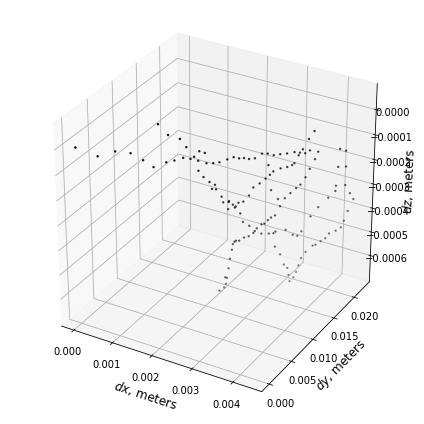

In [35]:
# Now, a 3D plot:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

# Coefficients:
c0, c1, c2 = pos_coefficients

# Plotting:
ax.scatter(dx - c0*dy, dy - c1*dx, dz - c2*dy, s = 2, c = 'k')

# Labels:
ax.set_xlabel('$dx$, meters', fontsize = 12)
ax.set_ylabel('$dy$, meters', fontsize = 12)
ax.set_zlabel('$dz$, meters', fontsize = 12)

fig.tight_layout()

fig.savefig('figures/3d_multivariate_fit_plot.pdf')

We see that the error localizes entirely around $(0, 0, 0)$.  Surely, there are regions where the model overall performs worse, but in general we can see that they collectively perform pretty well.  This is the reason why I didn't compare the fit in a 3D plot as well.  It would be rather difficult to see the difference.  Also, 3D plots don't stack well currently, so there would be information lost.  

Overall, it is clear that the multivariate least squares is far more meaningful than that of the univariate.

We can then take this a step further by taking advantage of $f(x, y, z, t) = r(t_i) = \sqrt{x(t_i)^2 + y(t_i)^2 + z(t_i)^2}$.  Since we know $x(t_i), y(t_i), z(t_i)$ and have an approximation to these values, we can make a direct comparison between the two.  As always, this is expanded on in `Theory`.  Since this is a time dependent equation, at least in the closed form, it's not particularly interesting for this section.  Regardless, this is a simple plot:

In [36]:
dr_approx = np.sqrt((c0*dy)**2 + (c1*dx)**2 + (c2*dz)**2)

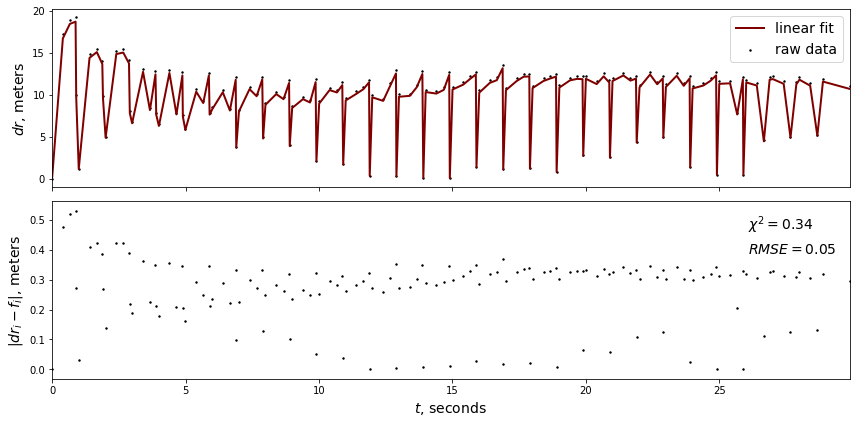

In [37]:
fig, axs = plt.subplots(2, 1, figsize = (12, 6), sharex = True)

# The comparison plots:

axs[0].scatter(time, dr, s = 2, c = 'k', label = 'raw data')
axs[0].plot(time, dr_approx, lw = 2, c = 'maroon', label = 'linear fit')

axs[0].set_ylabel('$dr$, meters', fontsize = 14)
axs[0].legend(loc = 'upper right', fontsize = 14)

# The error:
axs[1].scatter(time, abs(dr - dr_approx), s = 2, c = 'k')

axs[1].set_ylabel('$|dr_i - f_i|$, meters', fontsize = 14)
axs[1].set_xlabel('$t$, seconds', fontsize = 14)

axs[1].set_xlim(time[0], time[-1])

# Spoofing a legend:
axs[1].scatter(time[0], abs(dr - dr_approx)[0],
                       s = 0,
                       label = r'$\chi^2 = {:.2f}$'.format(chi2(dr, dr_approx, std_dr)))
    
axs[1].scatter(time[0], abs(dr - dr_approx)[0],
                       s = 0,
                       label = r'$RMSE = {:.2f}$'.format(rmse(dr, dr_approx, std_dr)))

axs[1].legend(loc = 'upper right', fontsize = 14, frameon = False)

fig.tight_layout()

fig.savefig('figures/multivariate_radial_fit_plot.pdf')

Ultimately, we see that the fit is infinitely better than that of the univariate data.  However, the issue with this is that it doesn't necessarily reflect a physical system.  In what world does a person move like this? It almost feels like an sinuisoidal system; surely, I wasn't running back and forth.  

So, this experiment must unfortunately be disregarded.  It is useful, however, to assert that the multivariate systems performs better as a fit, but not necessarily as a physical system.  In the end, I can only really blame `phyphox`, or the GPS tracker, since it appears that it has rather glaring accuracy issues.  If this data were far more accurate, not by a standard deviation of upwards of 20 meters, then certainly this would perform better.

Regardless, this is the end for now.  Maybe more can be done, but the system cannot be improved without the data first being highly accurate.  It's strange because the data suggests that only altitude is changing consequentially, when you would anticipate that longitude would be the only one majorly changing since my path is straight east on a fairly flat surface.  However, the data says otherwise.